In [1]:
%matplotlib inline

In [2]:
import shapely.geometry as sg
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import numpy

import foldable_robotics
import foldable_robotics.dxf 
import numpy
import shapely.geometry as sg
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics.manufacturing
import foldable_robotics.parts.castellated_hinge1
import idealab_tools.plot_tris
from math import pi, sin,cos,tan
import idealab_tools.text_to_polygons
foldable_robotics.display_height=200
foldable_robotics.line_width=.5

from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics
import foldable_robotics.dxf 
import foldable_robotics.manufacturing
import foldable_robotics.parts.castellated_hinge1
foldable_robotics.display_height=200
foldable_robotics.line_width=.5
#import workflow_support as ws

import os
import foldable_robotics.solidworks_support

In [3]:
def get_bodies(filename, layername, num_layers):
    body = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)

    bodies = [Layer(sg.Polygon(item)) for item in body]
    body = bodies.pop(0)
    for item in bodies:
        body ^= item
    body = body.to_laminate(num_layers)
    return body

In [4]:
def get_hinge_lines(filename,layername):
    hinge_lines1 = foldable_robotics.dxf.read_lines(filename,layer=layername)
    hinge_lines2 = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername)
    hinge_lines3 = []
    for points in hinge_lines2:
        hinge_lines3.append(points[:2])
    hinge_lines = hinge_lines1 +hinge_lines3
    return hinge_lines

In [5]:
def hinge_lines_to_hinges(hinge_lines,hinge):
    lam = Layer().to_laminate(len(hinge))
    all_hinges = []    
    for p3,p4 in hinge_lines:
        all_hinges.append(hinge.map_line_stretch((0,0),(1,0),p3,p4))
    all_hinges = lam.unary_union(*all_hinges)
    return all_hinges

In [6]:
def get_cuts(filename,layername,thickness,num_layers):
    cut_lines = foldable_robotics.dxf.read_lines(filename,layer=layername)
    cut_lines += foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)
    
    cuts = []
    for item in cut_lines:
        cuts.append(Layer(sg.LineString(item)))
    cuts = Layer().unary_union(*cuts)
    cuts<<=thickness/2
    cuts = cuts.to_laminate(num_layers)
    return cuts

In [7]:
def get_holes(filename, layername,num_layers):
    holes = foldable_robotics.dxf.read_circles(filename,layer='holes')
    
    holes2 = []
    for center, radius in holes:
        holes2.append(sg.Point(*center).buffer(radius))
    holes_layer = Layer(*holes2)
    holes_lam = holes_layer.to_laminate(num_layers)  
    return holes_lam

In [8]:
def hinge_width_calculator(desired_degrees,thickness):
    theta = (180-desired_degrees)*pi/180
    w=thickness/tan(theta)
    return w

In [9]:
def polys_to_layer(l1):
    l1 = [sg.Polygon(item) for item in l1]
    l11 = Layer(l1.pop(0))
    for item in l1:
        l11 ^= Layer(item)
    return l11

In [10]:
def output_pdf(filename,design2,x,y,layers_separate = True):
    design2 = design2.translate(x,y)
    design2=design2.scale(1/25.4,1/25.4)
    design2=design2.scale(foldable_robotics.pdf.ppi,foldable_robotics.pdf.ppi)
    if isinstance(design2,Laminate):
        if not layers_separate:
            p=foldable_robotics.pdf.Page(filename+'.pdf')
            for d in design2:
    #        d = design2[0]
                for item in d.exteriors()+d.interiors():
                    p.draw_poly(item)
            p.close()
        else:
            for ii,d in enumerate(design2):
                p=foldable_robotics.pdf.Page(filename+'{0:03f}.pdf'.format(ii))
                for item in d.exteriors()+d.interiors():
                    p.draw_poly(item)
                p.close()

    elif isinstance(design2,Layer):
        p=foldable_robotics.pdf.Page(filename+'.pdf')
        for item in design2.exteriors()+design2.interiors():
            p.draw_poly(item)
        p.close()

In [11]:
def build_layer_numbers(num_layers, text_size = None, prop=None):
    text_size = text_size or 1
    prop = prop or {'family':'Arial','size':text_size}
    layer_ids = []
    for ii in range(num_layers): 
    
        l = idealab_tools.text_to_polygons.text_to_polygons('Layer '+str(ii),prop=prop)
        layer_ids.append(l)
    
    layer_ids = [polys_to_layer(item) for item in layer_ids]
    layer_id = Laminate(*layer_ids)
    return layer_id

In [12]:
def build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive):
    num_layers = len(design2)

    layer_id = build_layer_numbers(num_layers,text_size=jig_diameter)

    design_outer = foldable_robotics.manufacturing.unary_union(design2)
    bb1= (design_outer<<jig_hole_spacing/2).bounding_box()
    (x1,y1),p2 = bb1.bounding_box_coords()
    w,h = bb1.get_dimensions()
    w2 = round(w/jig_hole_spacing)*jig_hole_spacing
    h2 = round(h/jig_hole_spacing)*jig_hole_spacing
    
    points = []
    points.append(sg.Point(x1,y1))
    points.append(sg.Point(x1+w2,y1))
    points.append(sg.Point(x1,y1+h2))
    points.append(sg.Point(x1+w2,y1+h2))
    
    layer_id = layer_id.translate(x1+jig_diameter,y1-jig_diameter/2)
    placement_holes2 = Layer(*points)
    placement_holes2<<=(jig_diameter/2)
    sheet = (placement_holes2<<10).bounding_box()
    placement_holes2=placement_holes2.to_laminate(num_layers)
    sheet=sheet.to_laminate(num_layers)
    
    removable_scrap = calculate_removable_scrap(design2,sheet,support_width,is_adhesive)
    
    web = (removable_scrap-placement_holes2)-layer_id
    return web,sheet

In [13]:
def calculate_removable_scrap(design,sheet,width,is_adhesive):
    '''this computes all removable scrap given a sheet, a design, and a clearance width'''
    all_scrap = sheet-design

    ru = foldable_robotics.manufacturing.not_removable_up(design,is_adhesive)
    rd = foldable_robotics.manufacturing.not_removable_down(design,is_adhesive)
    
    removable_scrap_up = all_scrap-(ru<<width)
    removable_scrap_down = all_scrap-(rd<<width)

    removable_scrap = removable_scrap_up|removable_scrap_down
    return removable_scrap

In [14]:
user_path = os.path.abspath(os.path.expanduser('~'))
user_path

'C:\\Users\\aakwa'

# 1 Layer Robot

In [68]:
l = 240
h = 40
seg = 30

radius = .5
num_perforations = 6
num_segments = num_perforations*2+1
num_points = num_segments+1
a=numpy.r_[0:h:num_points*1j]
lines = []
for ii in range(int(len(a)/2)-1):
    p1 = sg.Point(a[2*ii+1]+radius,0)
    p2 = sg.Point(a[2*ii+2]-radius,0)
    lines.append(sg.LineString((p1,p2)))
hinge = Layer(*lines)
hinge<<=radius

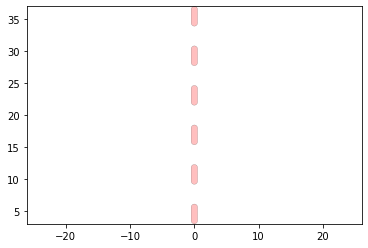

In [69]:
hinge = hinge.rotate(90)
hinge.plot()

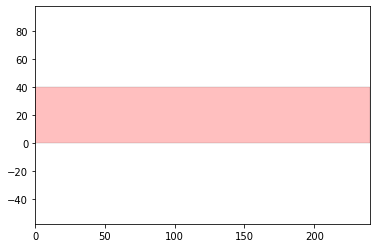

In [70]:
body = Layer(sg.Polygon([[0,0],[l,0],[l,h],[0,h]]))
body.plot()

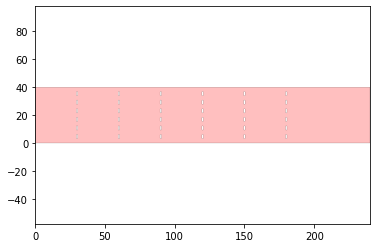

In [71]:
joint = body-hinge.translate(seg,0)-hinge.translate(seg*2,0)-hinge.translate(seg*3,0)-hinge.translate(seg*4,0)-hinge.translate(seg*5,0)-hinge.translate(seg*6,0)

joint.plot()

In [72]:
joint.export_dxf('Single_Layer')

# 5 Layer Robot

In [77]:
line = Layer(sg.LineString(((h,0),(0,0))))
line<<=radius

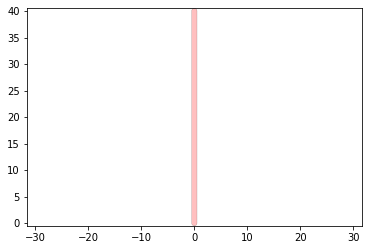

In [78]:
line = line.rotate(90)
line.plot()

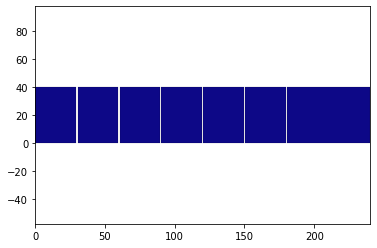

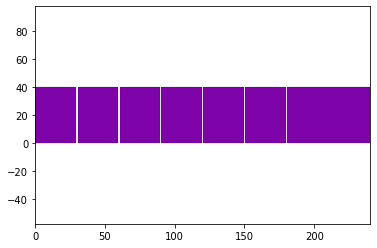

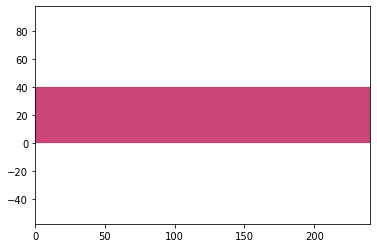

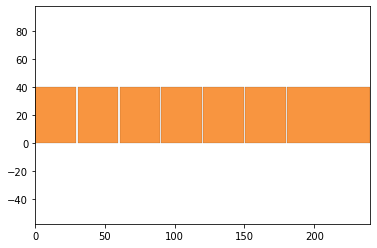

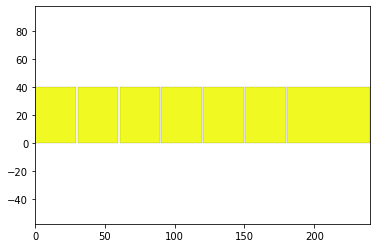

In [81]:
multilayer_hinge = Laminate(line,line,Layer(),line,line)
multilayer_body = Laminate(body,body,body,body,body)
joint5 = multilayer_body-multilayer_hinge.translate(seg*1,0)-multilayer_hinge.translate(seg*2,0)-multilayer_hinge.translate(seg*3,0)-multilayer_hinge.translate(seg*4,0)-multilayer_hinge.translate(seg*5,0)-multilayer_hinge.translate(seg*6,0)

joint5.plot_layers()

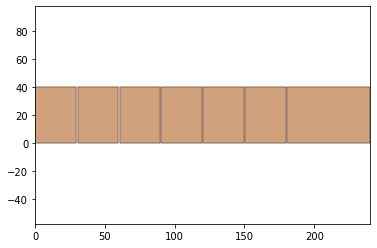

In [76]:
joint5.plot()

In [82]:
joint5.export_dxf('5_Layer')

# 5-Layer Manufacturing Design

In [23]:
folder = 'C:/Users/aakwa/Dropbox (ASU)/Term 8/EGR 557/Solidworks Model/'
input_filename = folder+'Full_Spine - Sheet1_Drawing View1.yaml'
output_file_name = 'design.dxf'

In [24]:
round_digits = 5
prescale=1000
body_prebuffer=-.01
joint_tolerance = 1e-5

round_digits = 2
prescale=1000
jig_diameter = 5
support_width = 1
kerf = .05
jig_hole_spacing=20
is_adhesive = [False,True,False,True,False]
arc_approx = 10

(<foldable_robotics.layer.Layer at 0x254fb332d60>,
  <foldable_robotics.solidworks_support.Component at 0x254fb65e550>])

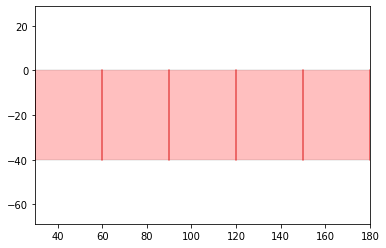

In [25]:
foldable_robotics.solidworks_support.process(input_filename,output_file_name,prescale,round_digits,body_prebuffer,joint_tolerance)

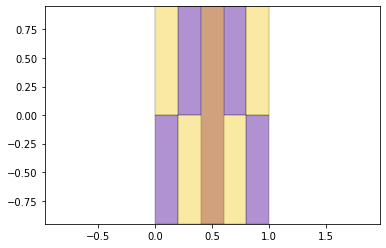

In [26]:
hinge = foldable_robotics.parts.castellated_hinge1.generate()
w=hinge_width_calculator(150,1.1)
hinge = hinge.scale(1,w)
hinge.plot()

In [27]:
NUMLAYERS = len(hinge)

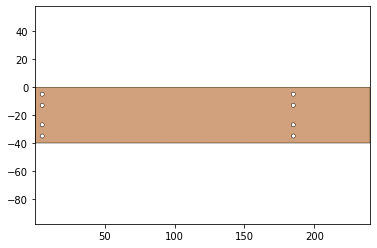

In [28]:
body = get_bodies(output_file_name,'body',NUMLAYERS)
body = foldable_robotics.manufacturing.cleanup(body,.02)
body.plot()

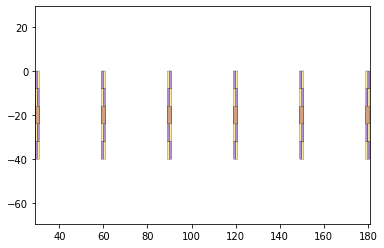

In [29]:
joint_lines= get_hinge_lines(output_file_name,'joints')
joints = hinge_lines_to_hinges(joint_lines,hinge)
joints = foldable_robotics.manufacturing.cleanup(joints,.02)
joints.plot()

In [30]:
cuts = get_cuts(output_file_name,'cuts',.02,NUMLAYERS)
#cuts.plot()

In [31]:
holes = get_holes(output_file_name,'holes',NUMLAYERS)
#holes.plot()

In [32]:
hole,dummy = foldable_robotics.manufacturing.calc_hole(joint_lines,w)
hole = hole.to_laminate(NUMLAYERS)
hole<<=.2
hole.plot()

('zero-size array to reduction operation minimum which has no identity',)


<Figure size 432x288 with 0 Axes>

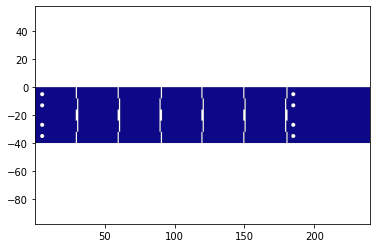

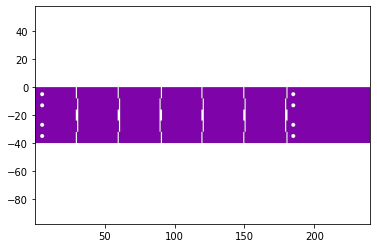

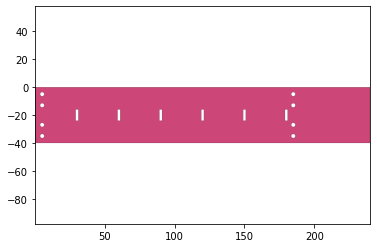

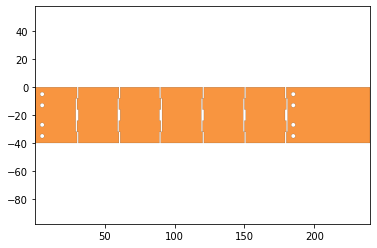

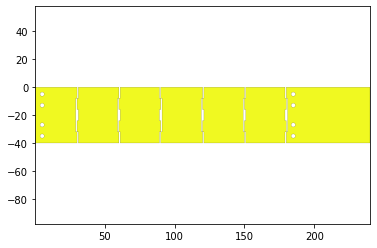

In [53]:
design2 = body- hole - joints - cuts - holes
design2.plot_layers()

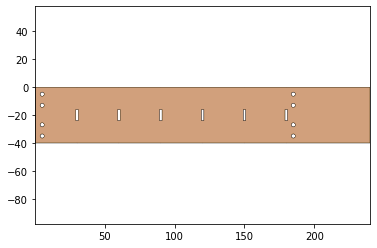

In [34]:
keepout =  foldable_robotics.manufacturing.keepout_laser(design2)
keepout.plot()

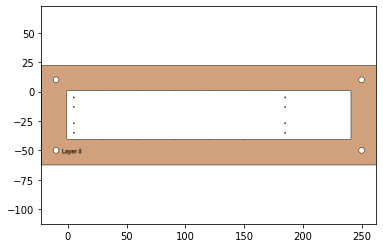

In [35]:
web,sheet=build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive)
web.plot()

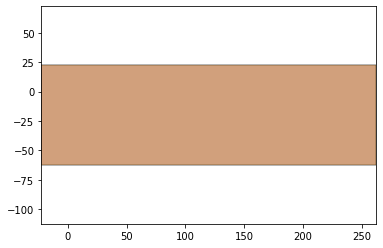

In [36]:
sheet.plot()

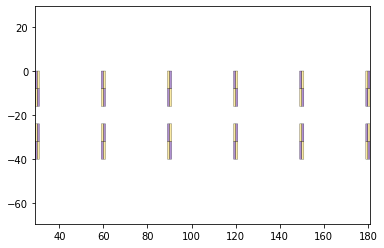

In [37]:
second_pass_scrap = sheet-keepout
first_pass_scrap = sheet - design2-second_pass_scrap
first_pass_scrap = foldable_robotics.manufacturing.cleanup(first_pass_scrap,.00001)
first_pass_scrap.plot()

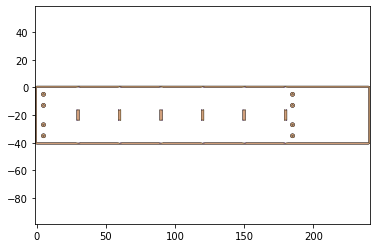

In [38]:
support = foldable_robotics.manufacturing.support(design2,foldable_robotics.manufacturing.keepout_laser,support_width,support_width/2)
support.plot()

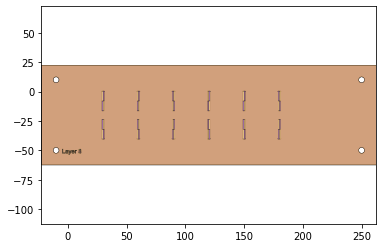

In [39]:
#Calculate the web by using only the material which can be cut, minus a gap determined by the support width.  Is that the only material you can use?
supported_design = web|design2|support
supported_design.plot()

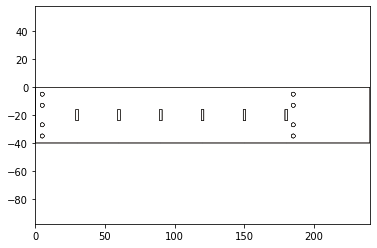

In [40]:
#cut_line = keepout<<kerf
cut_material = (keepout<<kerf)-keepout
cut_material.plot()

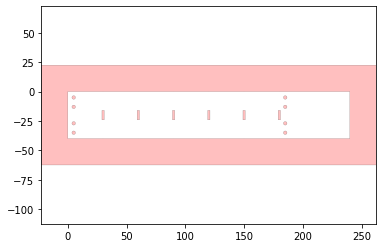

In [41]:
final_cut = sheet - keepout
final_cut = final_cut[0]
final_cut.plot()

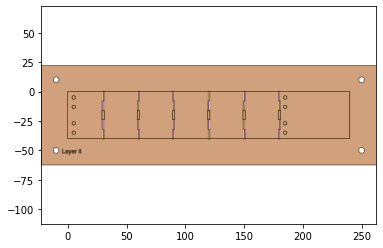

In [42]:
remaining_material = supported_design-cut_material
remaining_material.plot()

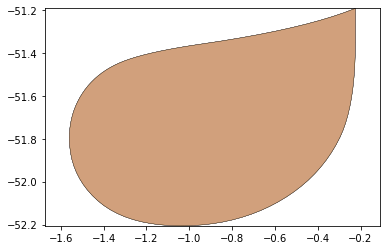

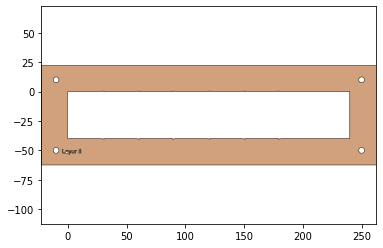

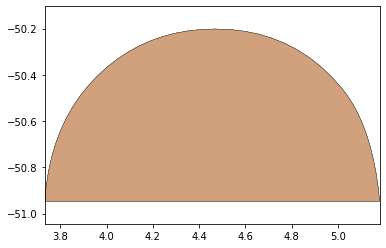

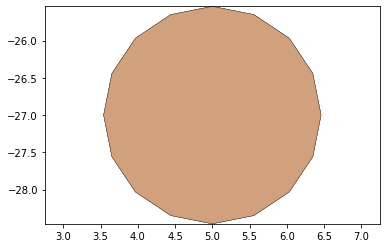

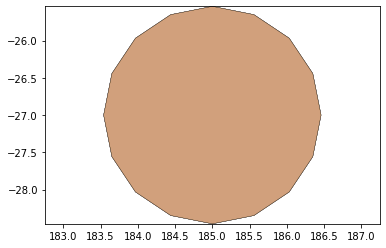

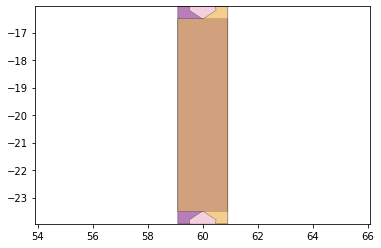

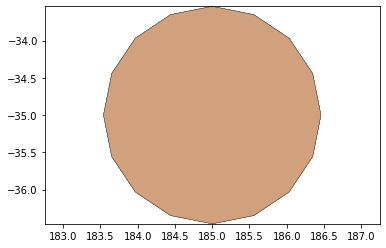

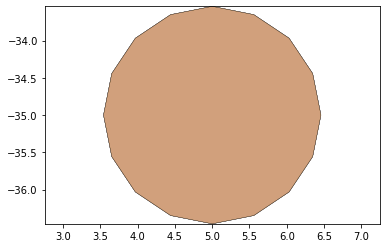

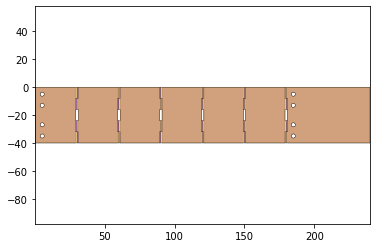

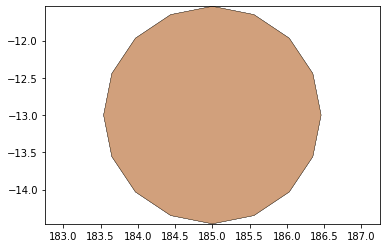

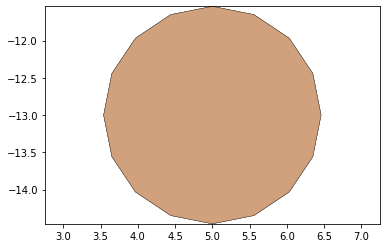

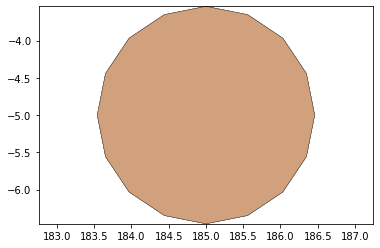

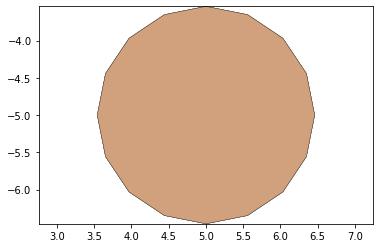

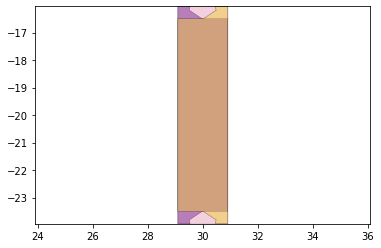

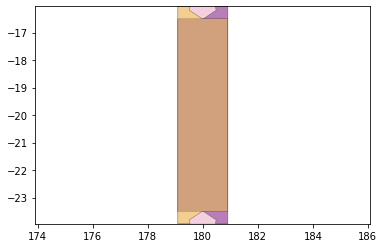

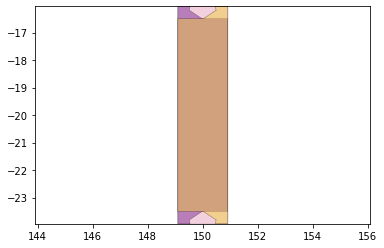

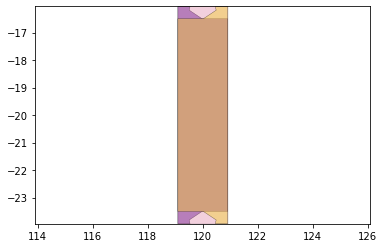

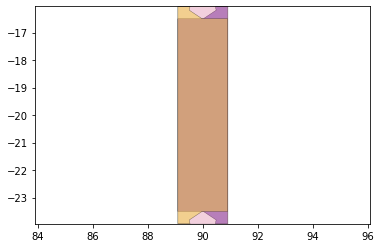

In [43]:
remaining_parts = foldable_robotics.manufacturing.find_connected(remaining_material,is_adhesive)
for item in remaining_parts:
    item.plot(new=True)

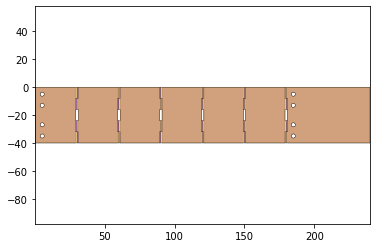

In [44]:
d3=design2>>1
for item in remaining_parts:
    if not (item&d3).is_null():
        break
item.plot()

In [45]:
check = (item^design2)
check>>=1e-5
check.plot()

('zero-size array to reduction operation minimum which has no identity',)


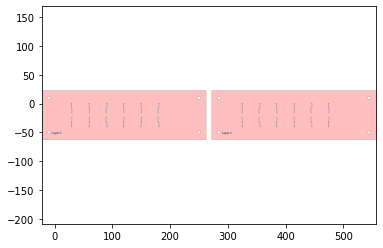

In [46]:
w,h = supported_design.get_dimensions()
p0,p1 = supported_design.bounding_box_coords()

rigid_layer = supported_design[0] | (supported_design[-1].translate(w+10,0))
rigid_layer.plot()

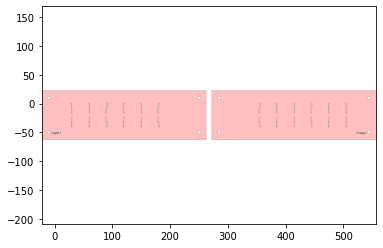

In [47]:
l4 = supported_design[3].scale(-1,1)
p2,p3 = l4.bounding_box_coords()
l4 = l4.translate(p0[0]-p2[0]+10+w,p0[1]-p2[1])

adhesive_layer = supported_design[1] | l4
adhesive_layer.plot()

In [48]:
first_pass = Laminate(rigid_layer,adhesive_layer,supported_design[2])

In [50]:
if check.is_null():
    first_pass.export_dxf('first_pass')
    final_cut.export_dxf('final_cut')